In [1]:
############################################################################
################       █████   █████████  ███████████       ################ 
################      ░░███   ███░░░░░███░█░░░███░░░█       ################ 
################       ░███  ███     ░░░ ░   ░███  ░        ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░███             ░███           ################ 
################       ░███ ░░███     ███    ░███           ################ 
################       █████ ░░█████████     █████          ################ 
################       ░░░░░   ░░░░░░░░░     ░░░░░          ################ 
############################################################################
########                IRI PROGRESSION MODEL (MPEDG)             ##########
################           Project: R27-252 EV             #################
########     Originally written by: Aravind Ramakhrishnan        ###########
############################################################################

# Created on Sat May 28 21:10:59 2022
# Last modified on Fri Jul 27 9:10:59 2024
# @author: Johann-Cardenas

In [71]:
# Import libraries
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
from scipy.optimize import minimize_scalar

# Start time tracker
start = time.time()

### **Traffic Growth (ESALs)**

In [84]:
def calculate_ESALs_y(ADT, T, T_f, r, y, D, L, N_days):
    ESALs_annual = []
    for year in range(1, y + 1):
        # Traffic growth factor
        G = (1 + r) ** year
        # ESALs for each category (weekday, weekend, holiday)
        ESALs = int(np.sum(ADT * T * T_f * G * D * L * N_days))
        ESALs_annual.append(ESALs)
    return ESALs_annual


def calculate_ESALs(ADT, T, T_f, r, y, D, L, N_days):
    ESALs_monthly = []
    G_monthly = (1 + r) ** (1 / 12)
    
    for year in range(1, y + 1):
        for month in range(1, 13):
            # Traffic growth factor for the current month
            G = G_monthly ** ((year - 1) * 12 + month)
            # Calculate ESALs for the current month
            ESALs = np.sum(ADT * T * T_f * G * D * L * (N_days))
            ESALs_monthly.append(ESALs)
    return ESALs_monthly


T_f = 0.52           # truck factor
r = 0.02             # growth rate
y = 50               # number of years
D = 1.0              # direction factor for two-way traffic
L = 0.42             # lane distribution factor

# Combine inputs into arrays
ADT = np.array([40000, 40000, 40000])  ## [ weekday, weekend, holiday]
T = np.array([0.25, 0.25, 0.25])  ## [ weekday, weekend, holiday]
N_days = np.array([201, 152, 13]) ## [ weekday, weekend, holiday]

# Calculate ESALs
ESALs_yearly = calculate_ESALs_y(ADT, T, T_f, r, y, D, L, N_days)

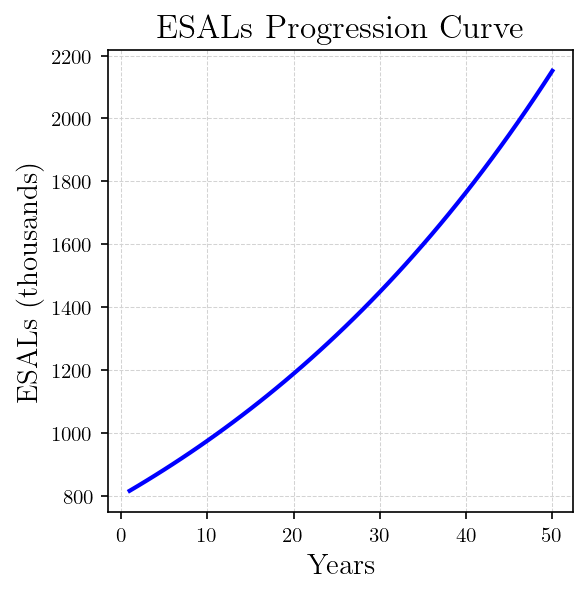

In [85]:
# Plot years vs ESAL progression
fig = plt.figure(figsize=(4, 4), dpi=150)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(range(1, y + 1), np.array(ESALs_yearly)/1e03, color='blue', linewidth=2.0)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('ESALs (thousands)', fontsize = 14)
plt.title('ESALs Progression Curve', fontsize = 16)
plt.grid(color='lightgrey', linestyle='--', linewidth=0.50, zorder=0)
plt.show()

In [86]:
ESALs_monthly = calculate_ESALs(ADT, T, T_f, r, y, D, L, N_days)

### **IRI Progression Model**

In [87]:
def calculate_IRI(IRI_initial, Thickness, ESALs, a, b, c):
    IRI = [IRI_initial]
    for ESAL in ESALs:
        IRI_next = IRI[-1] + a * (Thickness ** b) * (ESAL ** c)
        IRI.append(IRI_next)
    return IRI


def IRI_Drop(m, n, IRI_before):
    return IRI_before - (m * IRI_before + n)

In [94]:
IRI_initial = 60.0  #initial IRI
a = 16.0805
b = -0.6888
c = 0.1699
Thickness = 10 # inches

IRI_P1 = calculate_IRI(IRI_initial, Thickness, np.array(ESALs_yearly[0:9])/1000, a, b, c)
IRI_D1 = IRI_Drop(0.9037, -46.2114, IRI_P1[-1])
IRI_P2 = calculate_IRI(IRI_D1, Thickness, np.array(ESALs_yearly[10:19])/1000, a, b, c)
IRI_D2 = IRI_Drop(0.9037, -46.2114, IRI_P2[-1])
IRI_P3 = calculate_IRI(IRI_D2, Thickness, np.array(ESALs_yearly[20:29])/1000, a, b, c)
IRI_D3 = IRI_Drop(0.9037, -46.2114, IRI_P3[-1])
IRI_P4 = calculate_IRI(IRI_D3, Thickness, np.array(ESALs_yearly[30:39])/1000, a, b, c)
IRI_D4 = IRI_Drop(0.9037, -46.2114, IRI_P4[-1])
IRI_P5 = calculate_IRI(IRI_D4, Thickness, np.array(ESALs_yearly[40:49])/1000, a, b, c)
IRI_D5 = IRI_Drop(0.9037, -46.2114, IRI_P5[-1])

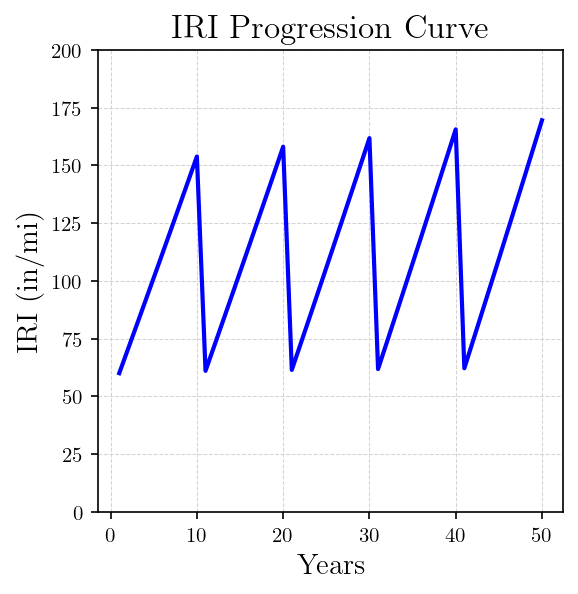

In [98]:
# concatenate IRI progression
IRI = IRI_P1 + IRI_P2 + IRI_P3 + IRI_P4 + IRI_P5

# Plot IRI progression curve
fig = plt.figure(figsize=(4, 4), dpi=150)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

plt.plot(range(1, y + 1), IRI, color='blue', linewidth=2.0)
plt.xlabel('Years', fontsize = 14)
plt.ylabel('IRI (in/mi)', fontsize = 14)
plt.ylim(0, 200)
plt.title('IRI Progression Curve', fontsize = 16)
plt.grid(color='lightgrey', linestyle='--', linewidth=0.50, zorder=0)
plt.show()